In [3]:
import numpy as np                    # For numerical operations and array handling
import matplotlib.pyplot as plt        # For displaying images and plots
import imageio.v3 as iio               # For loading/saving images (preferred)
import cv2                             # OpenCV for computer vision operations
import skimage as sk
import skimage.io as skio
from skimage import io, img_as_ubyte, color
from skimage.transform import rescale, resize
from scipy import signal
import time
import json
import helper


In [4]:
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

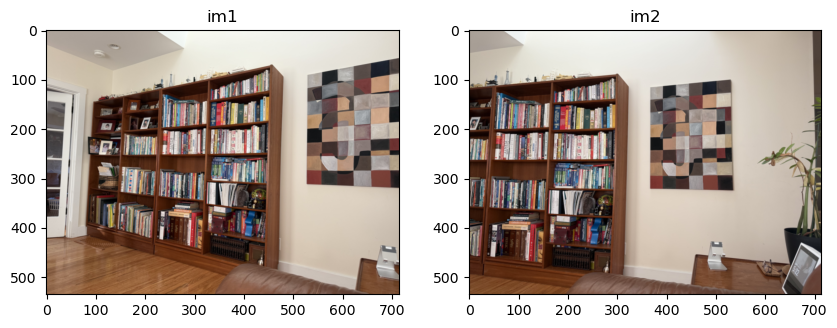

In [5]:
im1 = iio.imread('./data/part1/living_room1.png')
im2 = iio.imread('./data/part1/living_room2.png')

new_shape_1 = (im1.shape[0] // 8, im1.shape[1] // 8)
new_shape_2 = (im2.shape[0] // 8, im2.shape[1] // 8)

im1 = resize(im1, new_shape_1, anti_aliasing=True)
im2 = resize(im2, new_shape_2, anti_aliasing=True)

#iio.imwrite("./data/fridge_1_small.png", img_as_ubyte(im1))
#iio.imwrite("./data/fridge_2_small.png", img_as_ubyte(im2))

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)   # second plot
plt.imshow(im1)
plt.title("im1")

plt.subplot(1, 2, 2)   # 1 row, 2 columns, first plot
plt.imshow(im2)
plt.title("im2")

plt.show()


In [6]:
def createA(im1_point, im2_point):
    x = im1_point[0]
    y = im1_point[1]
    x_prime = im2_point[0]
    y_prime = im2_point[1]
    row_1 = [x, y, 1, 0, 0, 0, -1 * x * x_prime, -1 * y * x_prime]
    row_2 = [0, 0, 0, x, y, 1, -1 * x * y_prime, -1 * y * y_prime]
    return np.array([row_1, row_2])
            
def computeH(im1_points, im2_points):
    A = np.empty((0, 8))
    for i in range(len(im1_points)):
        rows = createA(im1_points[i], im2_points[i])
        A = np.vstack([A, rows])
    b = np.array(im2_points).flatten()
    #if len(im1_points) == 4:
        # Exact solution using np.linalg.solve
    #    h = np.linalg.solve(A, b)
    #elif len(im1_points) > 4:
        # Overdetermined, solve using least squares
    h, residuals, rank, s = np.linalg.lstsq(A, b)
    #else:
    #    raise ValueError("At least 4 points are required to compute homography.")

    H = np.append(h, 1).reshape(3, 3)
    return H

In [7]:
from helper import get_points
#with open('./data/fridge_1_small_fridge_2_small.json', 'r') as f:
#    correspondences = json.load(f)

#sanity check
#print(correspondences.keys())
#print(correspondences['im1Points'])
%matplotlib qt
correspondences = get_points(im1, im2)



Click corresponding points between the two images (left ↔ right).
Click on Image 1, then on Image 2, alternating.
Press Enter (or right-click) when done.

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Finished selecting points.

Collected 4 point pairs.
Points Image 1: [(241, 122), (456, 78), (221, 425), (434, 474)]
Points Image 2: [(58, 121), (296, 91), (33, 457), (279, 489)]


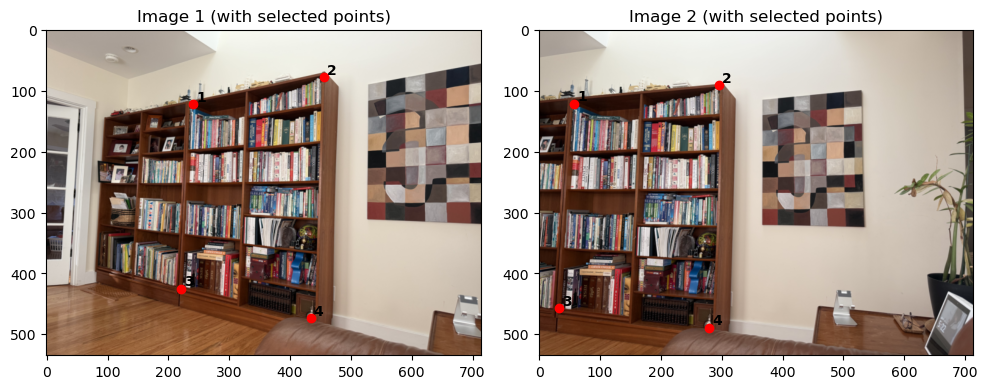

In [8]:
%matplotlib inline
def show_selected_points(im1, im2, points):
    points_1, points_2 = points  # unpack
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(im1)
    ax2.imshow(im2)

    ax1.set_title("Image 1 (with selected points)")
    ax2.set_title("Image 2 (with selected points)")

    # plot points on image 1
    for i, (x, y) in enumerate(points_1):
        ax1.plot(x, y, 'ro', markersize=6)
        ax1.text(x + 5, y - 5, f"{i+1}", color='black', fontsize=10, weight='bold')

    # plot points on image 2
    for i, (x, y) in enumerate(points_2):
        ax2.plot(x, y, 'ro', markersize=6)
        ax2.text(x + 5, y - 5, f"{i+1}", color='black', fontsize=10, weight='bold')

    plt.tight_layout()
    plt.show()
    

show_selected_points(im1, im2, correspondences)


In [9]:
plt.close('all')
%matplotlib inline
H = computeH(correspondences[0], correspondences[1])
np.set_printoptions(precision=4, suppress=True)
print(H)

[[   1.4013   -0.0034 -272.336 ]
 [   0.1397    1.2025  -44.8616]
 [   0.0005   -0.0001    1.    ]]


In [10]:
pts1 = np.array(correspondences[0], dtype=float)
pts1_h = np.hstack([pts1, np.ones((pts1.shape[0], 1))])  
mapped_h = (H @ pts1_h.T).T  
mapped = mapped_h[:, :2] / mapped_h[:, [2]]
print(mapped)

[[ 58. 121.]
 [296.  91.]
 [ 33. 457.]
 [279. 489.]]


In [11]:
#is our H stable? Yes it seems so since H << 10^8
print(np.linalg.cond(H))
print(H)

48796.756898482316
[[   1.4013   -0.0034 -272.336 ]
 [   0.1397    1.2025  -44.8616]
 [   0.0005   -0.0001    1.    ]]


In [12]:
def corner_boundaries(im, H):
    height, width = im.shape[:2] 

    #lets pipe through H to find the bounding box
    corners_h = np.array([
        [0, 0, 1],            # top-left
        [width - 1, 0, 1],    # top-right
        [0, height - 1, 1],   # bottom-left
        [width - 1, height - 1, 1]  # bottom-right
    ])

    # apply homography
    warped_corners = (H @ corners_h.T).T  # shape (4,3)

    # dehomogenize
    warped_corners /= warped_corners[:, [2]]
    return warped_corners

def warpImageNearestNeighbor(im, H):
    #lets warp each corner through the H matrix
    height, width = im.shape[:2] 

    warped_corners = corner_boundaries(im, H)

    x_min, y_min = np.floor(warped_corners[:,0].min()), np.floor(warped_corners[:,1].min())
    x_max, y_max = np.ceil(warped_corners[:,0].max()), np.ceil(warped_corners[:,1].max())
    
    width_new = int(x_max - x_min)
    height_new = int(y_max - y_min)

    warped = np.zeros((height_new, width_new, im.shape[2]), dtype=im.dtype)  
    H_inv = np.linalg.inv(H)
    
    for y in range(height_new):
        for x in range(width_new):
            origin_location = H_inv @ np.array([x + x_min, y + y_min, 1])
            origin_location /= origin_location[-1]
            x_origin = int(np.round(origin_location[0]))
            y_origin = int(np.round(origin_location[1]))
            if (0<= y_origin < height and 0<= x_origin <width):
                warped[y, x, :] = im[y_origin, x_origin, :]
            

    return warped



In [13]:
def warpImageNearestNeighborFast(im, H):
    height, width = im.shape[:2]

    corners_h = np.array([
        [0, 0, 1],
        [width - 1, 0, 1],
        [0, height - 1, 1],
        [width - 1, height - 1, 1]
    ])
    warped_corners = (H @ corners_h.T).T
    warped_corners /= warped_corners[:, [2]]
    x_min, y_min = np.floor(warped_corners[:, 0].min()), np.floor(warped_corners[:, 1].min())
    x_max, y_max = np.ceil(warped_corners[:, 0].max()), np.ceil(warped_corners[:, 1].max())
    width_new = int(x_max - x_min)
    height_new = int(y_max - y_min)

    ys, xs = np.meshgrid(np.arange(height_new), np.arange(width_new), indexing='ij')
    coords = np.stack([xs + x_min, ys + y_min, np.ones_like(xs)], axis=-1).reshape(-1, 3)

    H_inv = np.linalg.inv(H)
    coords_in = coords @ H_inv.T
    coords_in /= coords_in[:, [2]]

    x_in = np.round(coords_in[:, 0]).astype(int)
    y_in = np.round(coords_in[:, 1]).astype(int)

    valid = (x_in >= 0) & (x_in < width) & (y_in >= 0) & (y_in < height)

    warped = np.zeros((height_new, width_new, im.shape[2]), dtype=im.dtype)

    if im.ndim == 3:
        for c in range(im.shape[2]):
            warped[..., c].flat[valid] = im[y_in[valid], x_in[valid], c]
    else:
        warped.flat[valid] = im[y_in[valid], x_in[valid]]

    return warped


In [14]:
print(corner_boundaries(im1, H)[:,0].max())

540.020929803332


In [15]:
warped_im = warpImageNearestNeighbor(im1, H)

float64


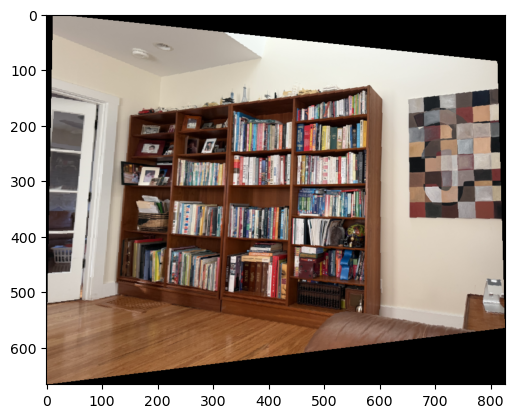

In [41]:
%matplotlib inline
plt.imshow(warped_im)
print(warped_im.dtype)

iio.imwrite("./output/living_room_NN.jpg", img_as_ubyte(warped_im))

In [42]:
def warpImageBilinear(im, H):
    height, width = im.shape[:2] 

    warped_corners = corner_boundaries(im, H)

    x_min, y_min = np.floor(warped_corners[:,0].min()), np.floor(warped_corners[:,1].min())
    x_max, y_max = np.ceil(warped_corners[:,0].max()), np.ceil(warped_corners[:,1].max())
    
    width_new = int(x_max - x_min)
    height_new = int(y_max - y_min)

    warped = np.zeros((height_new, width_new, 3), dtype=im.dtype)  
    H_inv = np.linalg.inv(H)
    
    for y in range(height_new):
        for x in range(width_new):
            origin_location = H_inv @ np.array([x + x_min, y + y_min, 1])
            origin_location /= origin_location[-1]
            #lets calculate the weighted sum
            x_origin = origin_location[0]
            y_origin = origin_location[1]
            x0 = int(np.floor(x_origin)) #lets get the floored pairs
            y0 = int(np.floor(y_origin)) 
            x1 = x0 + 1
            y1 = y0 + 1

            w00 = (x1 - x_origin) * (y1 - y_origin)
            w10 = (x_origin - x0) * (y1 - y_origin)
            w01 = (x1 - x_origin) * (y_origin - y0)
            w11 = (x_origin - x0) * (y_origin - y0)
            #check if in bounds
            if (0<= y0 < height and 0<= x0 <width):
                warped[y, x, :3] += im[y0, x0, :3] * w00
                #warped[y, x, 3] = 1
            if (0<= y0 < height and 0<= x1 < width):
                warped[y,x, :3] += im[y0, x1, :3] * w10
                #warped[y, x, 3] = 1
            if (0<=y1<height and 0<=x0<width):
                warped[y,x,:3] += im[y1, x0, :3] * w01
                #warped[y, x, 3] = 1
            if (0<=y1<height and 0<=x1<width):
                warped[y,x,:3] += im[y1, x1, :3] * w11
                #warped[y, x, 3] = 1
    
    warped = np.clip(warped, 0, 255)
    return warped

float64


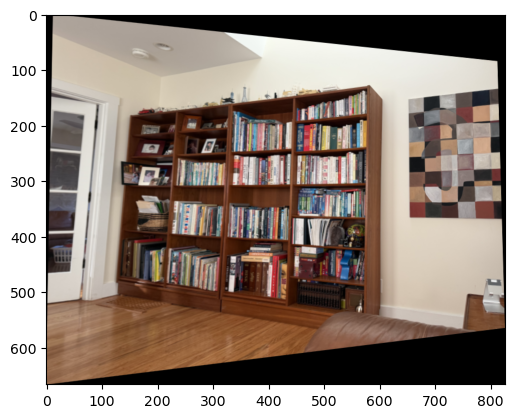

In [43]:
%matplotlib inline
warped_im_bilinear = warpImageBilinear(im1, H)
plt.imshow(warped_im_bilinear)
print(im1.dtype)

iio.imwrite("./output/living_room_bilinear.jpg", img_as_ubyte(warped_im_bilinear))


Lets try and rectify something

In [114]:
def rectification_bilinear(im, rect_points, H):
    height, width = im.shape[:2] 

    
    width_new = rect_points[3][0]
    height_new = rect_points[3][1]

    warped = np.zeros((height_new, width_new, 3), dtype=im.dtype)  
    H_inv = np.linalg.inv(H)
    
    for y in range(height_new):
        for x in range(width_new):
            origin_location = H_inv @ np.array([x, y, 1])
            origin_location /= origin_location[-1]
            #lets calculate the weighted sum
            x_origin = origin_location[0]
            y_origin = origin_location[1]
            x0 = int(np.floor(x_origin)) #lets get the floored pairs
            y0 = int(np.floor(y_origin)) 
            x1 = x0 + 1
            y1 = y0 + 1

            w00 = (x1 - x_origin) * (y1 - y_origin)
            w10 = (x_origin - x0) * (y1 - y_origin)
            w01 = (x1 - x_origin) * (y_origin - y0)
            w11 = (x_origin - x0) * (y_origin - y0)
            #check if in bounds
            if (0<= y0 < height and 0<= x0 <width):
                warped[y, x, :3] += im[y0, x0, :3] * w00
                #warped[y, x, 3] = 1
            if (0<= y0 < height and 0<= x1 < width):
                warped[y,x, :3] += im[y0, x1, :3] * w10
                #warped[y, x, 3] = 1
            if (0<=y1<height and 0<=x0<width):
                warped[y,x,:3] += im[y1, x0, :3] * w01
                #warped[y, x, 3] = 1
            if (0<=y1<height and 0<=x1<width):
                warped[y,x,:3] += im[y1, x1, :3] * w11
                #warped[y, x, 3] = 1
    
    warped = np.clip(warped, 0, 255)
    return warped

def rectification_NN(im, rect_points, H):
    height, width = im.shape[:2] 

    
    width_new = rect_points[3][0]
    height_new = rect_points[3][1]

    warped = np.zeros((height_new, width_new, 3), dtype=im.dtype)  
    H_inv = np.linalg.inv(H)
    
    for y in range(height_new):
        for x in range(width_new):
            origin_location = H_inv @ np.array([x, y, 1])
            origin_location /= origin_location[-1]
            x_origin = int(np.round(origin_location[0]))
            y_origin = int(np.round(origin_location[1]))
            if (0<= y_origin < height and 0<= x_origin <width):
                warped[y, x, :] = im[y_origin, x_origin, :]
    
    return warped

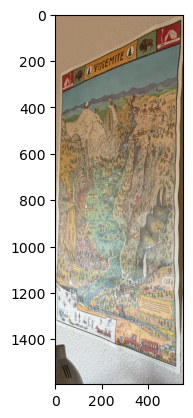

In [126]:
%matplotlib inline
surface = iio.imread('./data/part1/poster_cropped.png')
alignment = iio.imread('./data/part1/poster_rectification.png')

new_shape_1 = (surface.shape[0] // 2, surface.shape[1] // 2)
surface = resize(surface, new_shape_1, anti_aliasing=True)

#new_shape_2 = (alignment.shape[0] // 8, alignment.shape[1] // 8)
#alignment = resize(alignment, new_shape_2, anti_aliasing=True)

plt.imshow(surface)

In [127]:
print(surface.dtype)

float64


In [128]:
from helper import get_points_for_rectification
%matplotlib qt

points = get_points_for_rectification(surface)




Please select 4 points in the image for rectification.
Click in the order: top-left, top-right, bottom-left, bottom-right.
Press Enter (or right-click) when done.

Select point 1...

Select point 2...

Select point 3...

Select point 4...

Collected 4 points for rectification.
Points: [(29, 263), (549, 11), (5, 1329), (546, 1545)]


In [136]:
%matplotlib inline
height = 750
width = 500
corners = [
    (0, 0),                # top-left
    (width, 0),        # top-right
    (0, height),       # bottom-left
    (width, height)  # bottom-right
]
H_new = computeH(points, corners)

print(H_new)

[[   1.4455    0.0325  -50.4794]
 [   0.3743    0.7723 -213.9689]
 [   0.0009    0.0001    1.    ]]


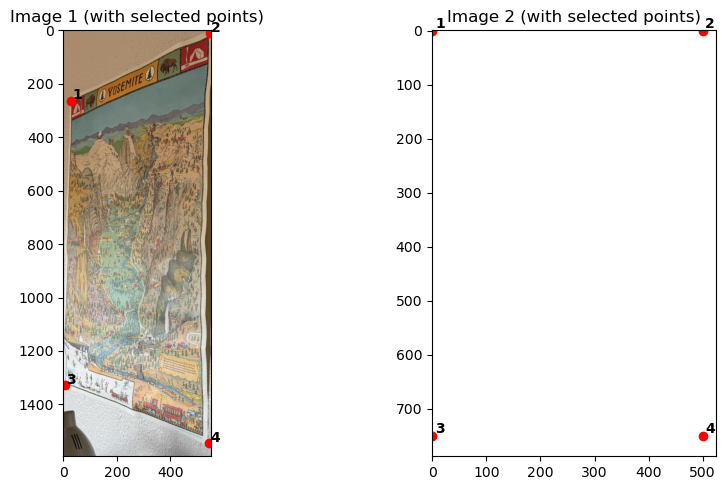

[[ -0.  -0.]
 [500.   0.]
 [ -0. 750.]
 [500. 750.]]


In [140]:
%matplotlib inline
alignment = np.ones((height, width, 3), dtype=surface.dtype)
show_selected_points(surface, alignment, [points, corners])


pts1 = np.array(points, dtype=float)
pts1_h = np.hstack([pts1, np.ones((pts1.shape[0], 1))])  
mapped_h = (H_new @ pts1_h.T).T  
mapped = mapped_h[:, :2] / mapped_h[:, [2]]
print(mapped)


In [141]:
corner_boundaries(surface, H_new)

array([[ -50.4794, -213.9689,    1.    ],
       [ 501.3331,   -5.206 ,    1.    ],
       [   1.2726,  926.7222,    1.    ],
       [ 503.2225,  771.535 ,    1.    ]])

In [142]:
poster_bilinear = rectification_bilinear(surface, corners ,H_new)
poster_nn = rectification_NN(surface, corners, H_new)

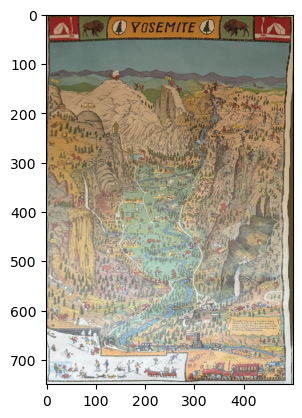

In [ ]:
plt.imshow(poster_bilinear)
#iio.imwrite("./output/poster_NN.jpg", img_as_ubyte(warped_im))

In [45]:
print(surface.dtype)

float64


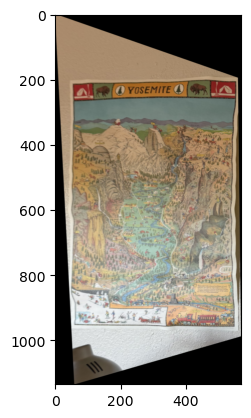

In [26]:
bilinear_warp = warpImageBilinear(surface, H_new)
plt.imshow(bilinear_warp)
#iio.imwrite("./output/poster_bilinear.jpg", img_as_ubyte(bilinear_warp))

In [35]:
def createMosaics(im1, im2, H):



    h_base, w_base = im2.shape[:2]
    base_corners = np.array([
    [0, 0],
    [w_base-1, 0],
    [0, h_base-1],
    [w_base-1, h_base-1]
    ])

    warped_corners = corner_boundaries(im1, H)[:, :2]

    all_corners = np.vstack([base_corners, warped_corners])
    x_min, y_min = np.floor(all_corners[:,0].min()), np.floor(all_corners[:,1].min()) 
    x_max, y_max = np.ceil(all_corners[:,0].max()), np.ceil(all_corners[:,1].max())

    canvas_width = int(x_max - x_min) 
    canvas_height = int(y_max - y_min) 
    
    mosaic_im1 = np.zeros((canvas_height + 1, canvas_width + 1, 3), dtype=im2.dtype)
    
    mosaic_im2 = np.zeros((canvas_height + 1, canvas_width + 1, 3), dtype=im2.dtype)

    offset_x = int(-x_min)
    offset_y = int(-y_min)

    

    warped_im1 = warpImageBilinear(im1, H)   # your warped image
    h_warped, w_warped = warped_im1.shape[:2]
    
    #just need to figure o  ut blending


    mosaic_im1[0:h_warped, 0:w_warped, :3] = warped_im1
    mosaic_im2[offset_y: offset_y + h_base, offset_x: offset_x+w_base, :] = im2
    
    
    return mosaic_im1, mosaic_im2




In [ ]:
mosaic_1, mosaic_2 = createMosaics(im1, im2, H)

#iio.imwrite('./output/canvas_1_living_room.jpg', img_as_ubyte(mosaic_1))
#iio.imwrite('./output/canvas_2_living_room.jpg', img_as_ubyte(mosaic_2))


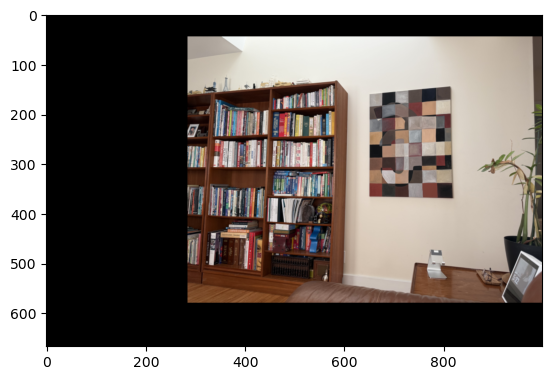

In [21]:
plt.imshow(mosaic_2)

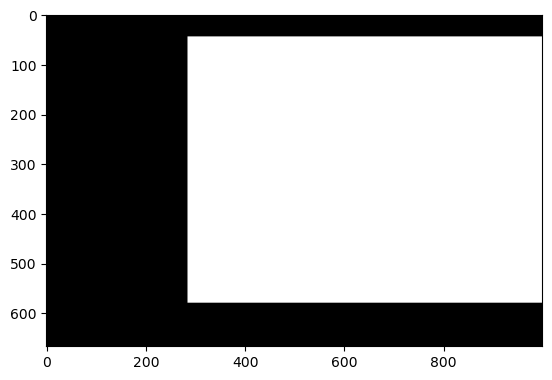

In [22]:
bw_1 = (color.rgb2gray(mosaic_1) > 0)
bw_2 = (color.rgb2gray(mosaic_2) > 0)
plt.imshow(bw_2, cmap = 'gray')

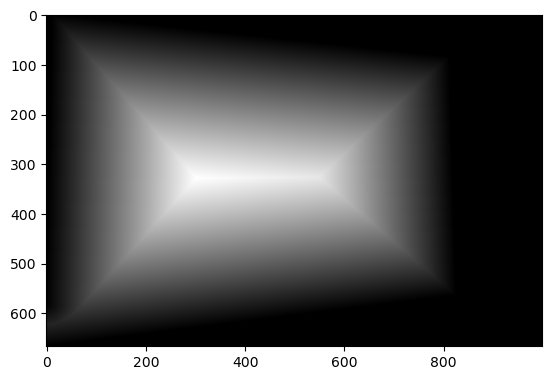

In [38]:
from scipy.ndimage import distance_transform_edt
D_map1 = normalize(distance_transform_edt(bw_1))
D_map2 = normalize(distance_transform_edt(bw_2))
plt.imshow(D_map1, cmap='gray')

iio.imwrite('./output/living_room_dmap1.jpg', img_as_ubyte(D_map1))
iio.imwrite('./output/living_room_dmap2.jpg', img_as_ubyte(D_map2))

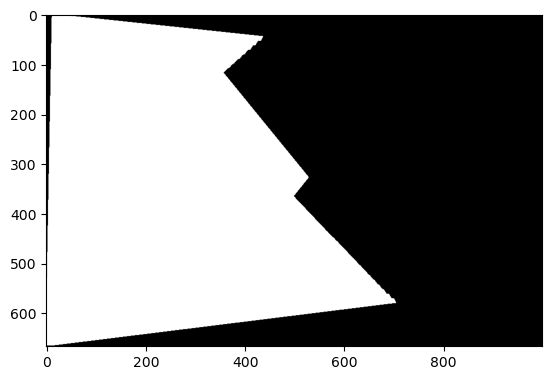

In [39]:
mask = (D_map1 > D_map2).astype(float)
plt.imshow(mask, cmap = 'gray')

iio.imwrite('./output/mask_living_room.jpg', img_as_ubyte(mask))

In [25]:
from helper import combined_color
mask_rgb = np.stack([mask, mask, mask], axis=-1)

combined_example = combined_color(mosaic_1, mosaic_2, mask_rgb, 5, 2, 2, 2)

empty_image = np.sum(combined_example, axis =0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17534787277634897..0.9978149801325336].


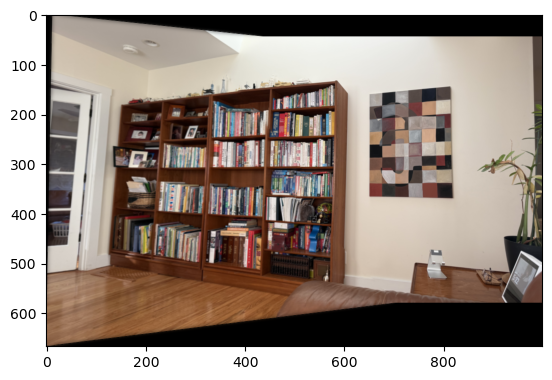

In [26]:
plt.imshow(empty_image)

In [79]:
def createMosaicWithoutBlending(im1, im2, H):

    h_base, w_base = im2.shape[:2]
    base_corners = np.array([
    [0, 0],
    [w_base-1, 0],
    [0, h_base-1],
    [w_base-1, h_base-1]
    ])

    warped_corners = corner_boundaries(im1, H)[:, :2]
    print(warped_corners)
    all_corners = np.vstack([base_corners, warped_corners])
    x_min, y_min = np.floor(all_corners[:,0].min()), np.floor(all_corners[:,1].min()) 
    x_max, y_max = np.ceil(all_corners[:,0].max()), np.ceil(all_corners[:,1].max())

    canvas_width = int(x_max - x_min) 
    canvas_height = int(y_max - y_min) 
    
    mosaic = np.zeros((canvas_height + 1, canvas_width + 1, 3), dtype=im2.dtype)
    
    #mosaic_im2 = np.zeros((canvas_height + 1, canvas_width + 1, 3), dtype=im2.dtype)

    offset_x = int(-x_min)
    offset_y = int(-y_min)

    

    warped_im1 = warpImageBilinear(im1, H)   # your warped image, can decide if you want to do closest
    h_warped, w_warped = warped_im1.shape[:2]

    #if warped image should be to the right
    #mosaic[offset_y:offset_y + h_base, offset_x:offset_x + w_base] = warped_im1
    #mosaic[0:h_base, 0:w_base] = im2

    #if warped image should be to the left
    mosaic[0:h_warped, 0:w_warped, :3] = warped_im1
    mosaic[offset_y: offset_y + h_base, offset_x: offset_x+w_base, :] = im2
    
    
    return mosaic

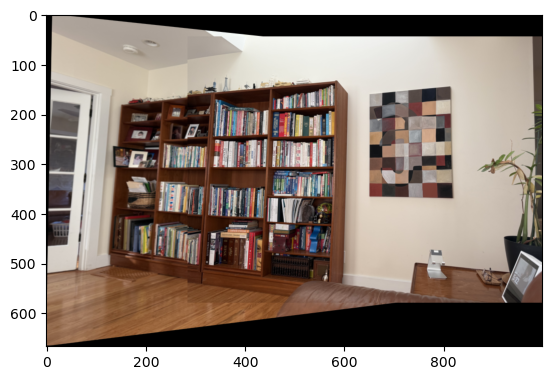

In [37]:
without_blending=createMosaicWithoutBlending(im1, im2, H)
plt.imshow(without_blending)
iio.imwrite("./output/living_room_without_blending.jpg", img_as_ubyte(without_blending))

In [30]:
def blendMosaics(mosaic_1, mosaic_2):
    bw_1 = (color.rgb2gray(mosaic_1) > 0)
    bw_2 = (color.rgb2gray(mosaic_2) > 0)
    D_map1 = normalize(distance_transform_edt(bw_1))
    D_map2 = normalize(distance_transform_edt(bw_2)) 
    mask = (D_map1 > D_map2).astype(float)
    mask_rgb = np.stack([mask, mask, mask], axis=-1)

    combined_example = combined_color(mosaic_1, mosaic_2, mask_rgb, 5, 2, 2, 2)

    return np.sum(combined_example, axis =0)
    

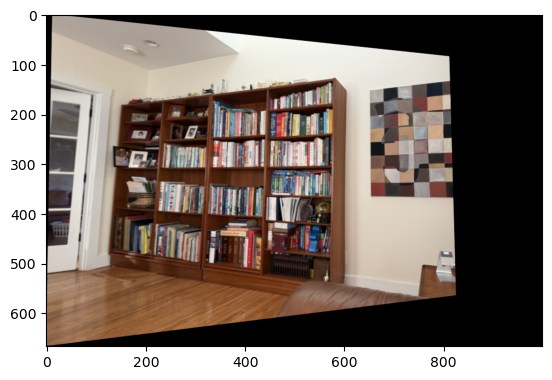

In [31]:
plt.imshow(mosaic_1)

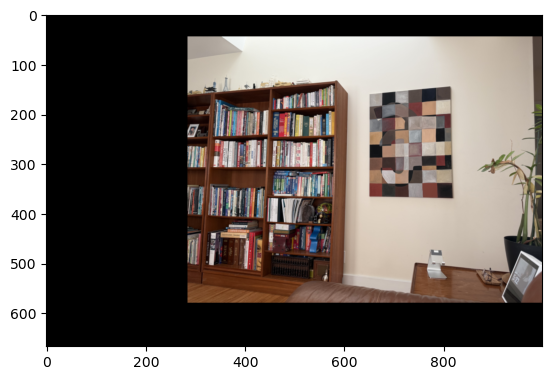

In [32]:
plt.imshow(mosaic_2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17534787277634897..0.9978149801325336].


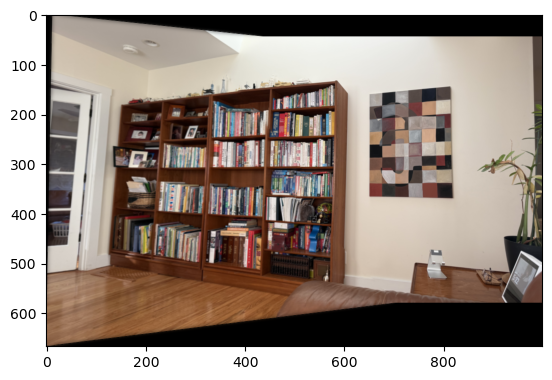

In [40]:
blended_living_room = blendMosaics(mosaic_1, mosaic_2)
plt.imshow(blended_living_room)

iio.imwrite('./output/living_room_blended.jpg', img_as_ubyte(blended_living_room))


In [ ]:
#steps for blending
#calculate homography matrix
#create the mosaics --> this will have two outputs
#blend the mosaics --> this will have the final product

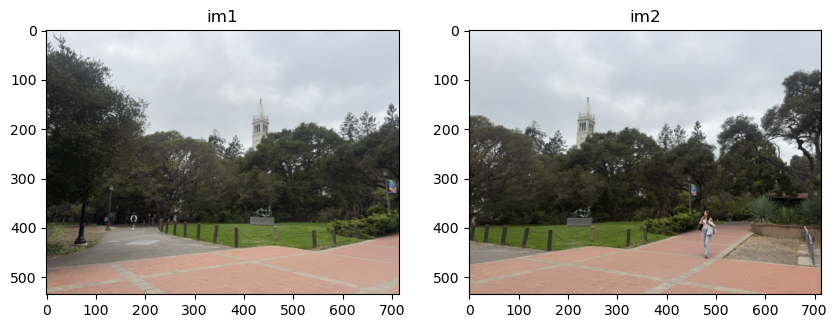

In [ ]:
campanile_1 = iio.imread("./data/part1/campanile_1.png")
campanile_2 = iio.imread("./data/part1/campanile_2.png")

street_1_shape = (campanile_1.shape[0] // 8, campanile_1.shape[1] // 8)
street_2_shape = (campanile_2.shape[0] // 8, campanile_2.shape[1] // 8)


campanile_1 = resize(campanile_1, street_1_shape, anti_aliasing=True)
campanile_2 = resize(campanile_2, street_2_shape, anti_aliasing=True)

#iio.imwrite("./output/campanile_1_small.png", img_as_ubyte(campanile_1))
#iio.imwrite("./output/campanile_2_small.png", img_as_ubyte(campanile_2))

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)   # second plot
plt.imshow(campanile_1)
plt.title("im1")

plt.subplot(1, 2, 2)   # 1 row, 2 columns, first plot
plt.imshow(campanile_2)
plt.title("im2")

plt.show()

In [56]:
#i want to morph street 2 to street 1
%matplotlib qt
street_points = get_points(campanile_1, campanile_2)

Click corresponding points between the two images (left ↔ right).
Click on Image 1, then on Image 2, alternating.
Press Enter (or right-click) when done.

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Select corresponding point on Image 2...

Select next point on Image 1 (press Enter when done)...
Finis

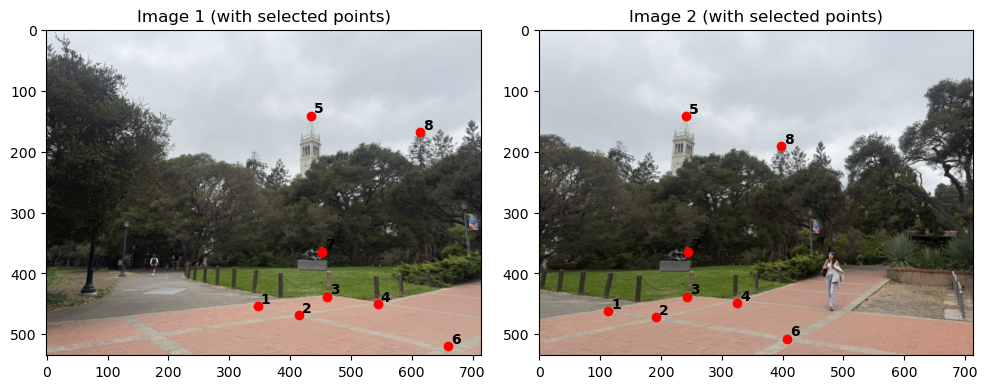

In [101]:
show_selected_points(campanile_1, campanile_2, street_points)

8


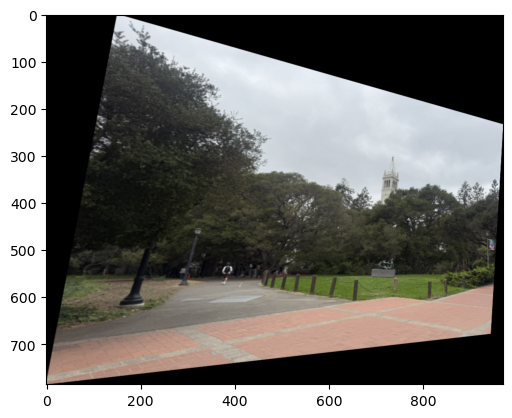

In [105]:
%matplotlib inline
print(len(street_points[0]))
H_street = computeH(street_points[0], street_points[1])
warped_campanile_1 = warpImageBilinear(campanile_1, H_street)
warped_campanile_2 = warpImageNearestNeighbor(campanile_1, H_street)
plt.imshow(warped_campanile_1)
iio.imwrite("./output/warped_campanile_bilinear.jpg", img_as_ubyte(warped_campanile_1))
iio.imwrite("./output/warped_campanile_NN.jpg", img_as_ubyte(warped_campanile_2))

In [84]:
campanile_mosaic_1, campanile_mosaic_2 = createMosaics(campanile_1, campanile_2, H_street)


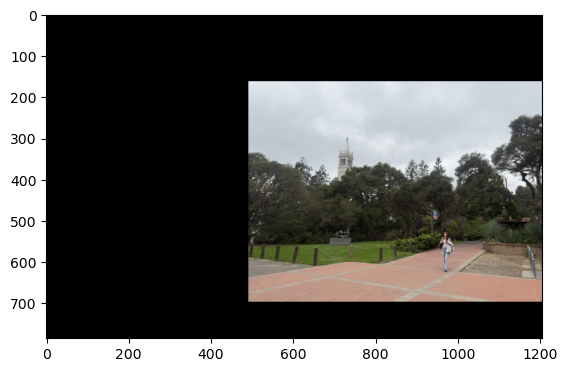

In [85]:
plt.imshow(campanile_mosaic_2)

[[-272.336   -44.8616]
 [ 526.4732   39.6594]
 [-284.9961  620.863 ]
 [ 540.0209  519.1052]]


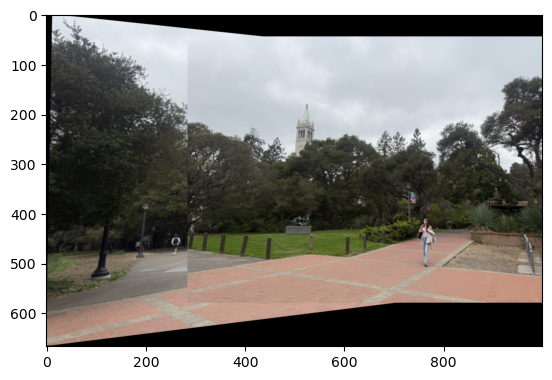

In [103]:
unblended_campanile = createMosaicWithoutBlending(campanile_1, campanile_2, H)
plt.imshow(unblended_campanile)
iio.imwrite("./output/unblended_campanile.jpg", img_as_ubyte(unblended_campanile))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18169959278280093..0.9983892037047579].


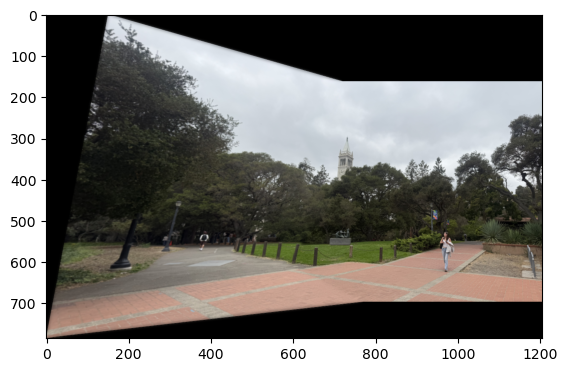

In [104]:
blended_campanile = blendMosaics(campanile_mosaic_1, campanile_mosaic_2)
plt.imshow(blended_campanile)
iio.imwrite("./output/blended_campanile.jpg", img_as_ubyte(blended_campanile))

Rectification of another image

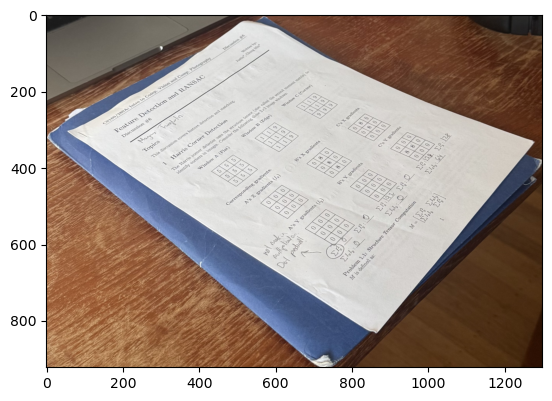

In [119]:
discussion = iio.imread('./data/part1/discussion_cropped.png')
discussion_shape = (discussion.shape[0] // 2, discussion.shape[1] // 2)

discussion = resize(discussion, discussion_shape, anti_aliasing=True)

iio.imwrite('./output/discussion_cropped_small.jpg', img_as_ubyte(discussion))
plt.imshow(discussion)

In [122]:
from helper import get_points_for_rectification
%matplotlib qt

discussion_points = get_points_for_rectification(discussion)

Please select 4 points in the image for rectification.
Click in the order: top-left, top-right, bottom-left, bottom-right.
Press Enter (or right-click) when done.

Select point 1...

Select point 2...

Select point 3...

Select point 4...

Collected 4 points for rectification.
Points: [(60, 307), (532, 10), (863, 830), (1274, 339)]


In [123]:
%matplotlib inline
height = 750
width = 500
corners = [
    (0, 0),                # top-left
    (width, 0),        # top-right
    (0, height),       # bottom-left
    (width, height)  # bottom-right
]
H_discussion = computeH(discussion_points, corners)

bilinear_discussion = rectification_bilinear(discussion, corners, H_discussion)
NN_discussion = rectification_NN(discussion, corners, H_discussion)
#bilinear_discussion = warpImageBilinear(discussion, H_discussion)

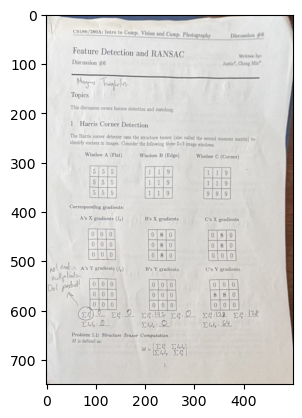

In [124]:
plt.imshow(bilinear_discussion)
iio.imwrite("./output/bilinear_discussion.jpg", img_as_ubyte(bilinear_discussion))


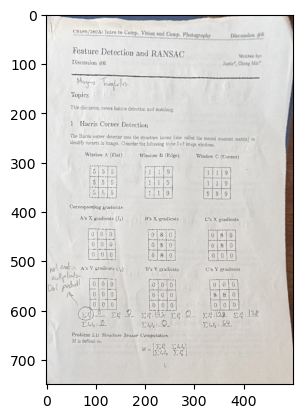

In [125]:
plt.imshow(NN_discussion)
iio.imwrite('./output/NN_discussion.jpg', img_as_ubyte(NN_discussion))